## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [2]:
## your code here
debar = pd.read_csv(r"/Users/fintanletzelter/Documents/GitHub/QSS20_S24/problemsets/pset2/pset2_inputdata/debar.csv")
print(debar.head())
print(debar.shape)


                               Name     City, State  \
0                    J&J Harvesting       Leads, ND   
1            Stahlman Apiaries, Inc       Selby, SD   
2                     Trust Nursery     Pulaski, NY   
3             Anton Fertilizer Inc.     Dighton, KS   
4  Great Plains Fluid Service, Inc.  Greensburg, KS   

                                        Violation Duration Start date  \
0  Failure to respond to audit (partial response)  2 years  1/19/2014   
1  Failure to respond to audit (partial response)   1 year  2/19/2015   
2  Failure to respond to audit (partial response)   1 year  3/21/2014   
3       Failure to respond to audit (no response)  2 years  3/30/2014   
4       Failure to respond to audit (no response)  2 years  3/30/2014   

    End date  
0  1/18/2016  
1  2/14/2016  
2  3/20/2015  
3  3/29/2016  
4  3/29/2016  
(114, 6)


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [3]:
## your code here
print(debar.shape[0])
print(len(set(debar.Name)))

print("There are multiple rows for some employers")

114
98
There are multiple rows for some employers


## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [4]:
## your code here
debar["is_repeated"] = debar["Name"].map(debar["Name"].value_counts()) > 1
print(debar[debar["is_repeated"] == True])

mult_debar = debar[debar["is_repeated"] == True]
print(mult_debar.shape)
print(mult_debar.head())

                                        Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX   
11                     Loewen Harvesting LLC   Brownsville, TX   
12               Rollo Farm Labor Contractor         Miami, FL   
14                             Sharon Mathis        Tifton, GA   
15                                 SRT Farms        Morton, TX   
16                               Mark Duncan     Roosevelt, UT   
17          Maple Ridge Custom Services, LLC     Altheimer, AK   
18                                 F&W Farms       Ingalls, KS   
19                        Cisco Produce Inc.         Cairo, GA   
21   Old Tree Farms/Verpaalen Custom Service         Volga, SD   
24               Rollo Farm Labor Contractor         Miami, FL   
25                     Loewen Harvesting LLC    Brownfield, TX   
28     Cad

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [5]:
state_map = {'Texas': 'TX', "Brownfield": "Brownsville", "AK": "AR", "Utah": "UT"}

def clean_city_state(city_state):
    for keyword, replacement in state_map.items():
        if keyword in city_state:
            return city_state.replace(keyword, replacement)
    return city_state

mult_debar['City, State'] = mult_debar['City, State'].apply(clean_city_state)


for name in mult_debar['Name']:
    for name2 in mult_debar['Name']:
        if name == name2:
            stardate2 =  mult_debar['Start date']
            mult_debar['Start date 2'] = stardate2


mult_debar['start_date_viol1'] = mult_debar.groupby(['Name', 'City, State'])['Start date'].transform('first')
print(mult_debar['start_date_viol1'])

mult_debar['start_date_viol2'] = mult_debar.groupby(['Name', 'City, State'])['Start date 2'].transform('last')
print(mult_debar['start_date_viol2'])


mult_debar_wide = mult_debar.pivot_table(index=['Name', 'City, State'],
                                         columns=None,
                                         values=["start_date_viol1", "start_date_viol2"],
                                         aggfunc='first')

mult_debar_wide.reset_index(inplace=True)

print("Head of mult_debar_wide:")
print(mult_debar_wide)
print("\nShape of mult_debar_wide:", mult_debar_wide.shape)



6        5/9/2014
7        7/6/2014
8       7/20/2014
11      8/20/2014
12      8/23/2014
14     11/16/2014
15     11/16/2014
16     11/16/2014
17     11/16/2014
18     12/10/2014
19     12/10/2014
21     12/11/2014
24      8/23/2014
25      8/20/2014
28      7/20/2014
29       7/6/2014
30       5/9/2014
31      2/13/2015
51     12/11/2014
55      2/13/2015
56     12/10/2014
58     12/10/2014
59     11/16/2014
60     11/16/2014
61     11/16/2014
62     11/16/2014
73      6/16/2016
89      6/16/2016
103      2/9/2018
106       7/17/19
109      2/9/2018
111       7/17/19
Name: start_date_viol1, dtype: object
6        5/9/2014
7        7/6/2014
8       7/20/2014
11      8/20/2014
12      8/23/2014
14     11/16/2014
15     11/16/2014
16     11/16/2014
17     11/16/2014
18     12/10/2014
19     12/10/2015
21      12/1/2014
24      8/23/2014
25      8/20/2014
28      7/20/2014
29       7/6/2014
30       5/9/2014
31      2/13/2015
51      12/1/2014
55      2/13/2015
56     12/10/2015
58     1

/var/folders/_f/t13xr4514214419m1ty47v1r0000gn/T/ipykernel_54071/2161131251.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar['City, State'] = mult_debar['City, State'].apply(clean_city_state)
/var/folders/_f/t13xr4514214419m1ty47v1r0000gn/T/ipykernel_54071/2161131251.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar['Start date 2'] = stardate2
/var/folders/_f/t13xr4514214419m1ty47v1r0000gn/T/ipykernel_54071/2161131251.py:19: SettingWithCopyWarning: 
A value is trying to be set on

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [6]:
## your code here
mult_debar_wide["is_dup"] = (mult_debar_wide["start_date_viol1"] == mult_debar_wide["start_date_viol2"])


duplicates = mult_debar_wide[mult_debar_wide['is_dup']]
duplicates.shape

non_duplicates = debar[~debar['Name'].isin(duplicates['Name'])]

non_duplicates.drop(columns='is_repeated', inplace=True)

debar_clean = pd.concat([duplicates, non_duplicates], axis=0)

print(debar_clean.shape)
print(debar_clean["Name"].nunique())

(13, 5)

(101, 9)
98


/var/folders/_f/t13xr4514214419m1ty47v1r0000gn/T/ipykernel_54071/1701633796.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_duplicates.drop(columns='is_repeated', inplace=True)


# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset4_inputdata`

In [7]:
# your code here to load the data 

jobs = pd.read_csv(r"/Users/fintanletzelter/Documents/GitHub/QSS20_S24/problemsets/pset2/pset2_inputdata/jobs.csv")
print(jobs.head)

<bound method NDFrame.head of              CASE_NUMBER                           CASE_STATUS  \
0     H-300-20199-721302      Determination Issued - Withdrawn   
1     H-300-20231-773906  Determination Issued - Certification   
2     H-300-20231-774123  Determination Issued - Certification   
3     H-300-20231-774151  Determination Issued - Certification   
4     H-300-20231-774508  Determination Issued - Certification   
...                  ...                                   ...   
2715  H-300-20351-963307  Determination Issued - Certification   
2716  H-300-20351-963399  Determination Issued - Certification   
2717  H-300-20351-964097  Determination Issued - Certification   
2718  H-300-20351-965435  Determination Issued - Certification   
2719  H-300-20352-967311  Determination Issued - Certification   

                RECEIVED_DATE            DECISION_DATE  \
0     2020-07-17 14:50:40.840  2020-10-01 00:00:00.000   
1     2020-08-20 10:38:15.620  2020-10-01 00:00:00.000   
2  

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [8]:
## your code here

jobs_debar = jobs.merge(debar_clean, left_on = "EMPLOYER_NAME", right_on = "Name", how = "inner")
print(jobs_debar)

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20287-876656  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-10-20 09:20:32.010  2020-11-09 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    Y                 Seasonal   

  EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  ...  \
0                Y  Rafael Barajas            NaN  ...   

  TOTAL_ADDENDUM_A_RECORDS            Name       City, State start_date_viol1  \
0                        7  Rafael Barajas  Sebring, Florida              NaN   

  start_date_viol2 is_dup                         Violation  Duration  \
0              NaN    NaN  Non-payment of certification fee    1 year   

   Start date   End date  
0   9/23/2016  9/22/2017  

[1 rows x 147 columns]


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [9]:
## insert your code to turn into uppercase here

jobs_names = [str.upper(name) for name in jobs["EMPLOYER_NAME"]]

debar_names = [str.upper(name) for name in debar_clean["Name"]]

In [10]:
## insert your code for the random sample
print(jobs["EMPLOYER_NAME"].sample(n = 15))
print(debar_clean["Name"].sample(n = 15))

753                                    Maaske LLC
1104                             VG Farm Ventures
19                           Hays Harvesting Inc.
2586    David & LaLain Wilkison Farms Partnership
1899                             Agrico Labor LLC
746                 Lance & Lisa Funk Partnership
2062                                Countiss Farm
964                         Signet Builders, Inc.
237                     WESTERN RANGE ASSOCIATION
2329                     Honey Land Farms II, LLC
2592                           Caston Blueberries
1632                       Ralph & Beverly Fisher
2271                       Live Oak Gardens, Ltd.
863                                  Aaron Celley
201                     WESTERN RANGE ASSOCIATION
Name: EMPLOYER_NAME, dtype: object
12                    SRT Farms
101     Monica Saavedra (Agent)
69               Quentin Schell
2                 Trust Nursery
113                 Delia Rojas
38                  Leslie Cook
48        Peach Crest F

In [11]:
## insert your code for assigning the uppercase names back to the data
jobs["EMPLOYER_NAME"] = jobs_names
debar_clean["Name"] = debar_names

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [12]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"




In [13]:
## insert your code here with the regex pattern for part A

pattern1 = r"(\s+)(INC|CO|LLC)(\.)?"

## insert your code to use re.sub to apply the pattern to the test cases for part B


re.search(pattern1, pos_example_1)
re.search(pattern1, pos_example_2)
re.search(pattern1, neg_example)

<re.Match object; span=(13, 18), match=' INC.'>

<re.Match object; span=(15, 19), match=' CO.'>

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [14]:
## your code here to clean the columns

debar_clean["name_clean"] = [re.sub(pattern1, r"\1\2", name) for name in debar_clean["Name"]]
jobs["name_clean"] = [re.sub(pattern1, r"\1\2", name) for name in jobs["EMPLOYER_NAME"]]

In [15]:
## your code here to print the head
print(jobs[jobs["EMPLOYER_NAME"] != jobs["name_clean"]].head())
print(debar_clean[debar_clean["Name"] != debar_clean["name_clean"]].head())


           CASE_NUMBER                                     CASE_STATUS  \
4   H-300-20231-774508            Determination Issued - Certification   
7   H-300-20233-780540  Determination Issued - Certification (Expired)   
14  H-300-20240-791807  Determination Issued - Certification (Expired)   
17  H-300-20244-795767            Determination Issued - Certification   
18  H-300-20245-799651            Determination Issued - Certification   

              RECEIVED_DATE            DECISION_DATE  \
4   2020-08-20 10:17:34.530  2020-10-01 00:00:00.000   
7   2020-09-04 14:26:00.270  2020-10-01 00:00:00.000   
14  2020-09-17 18:57:56.030  2020-10-01 00:00:00.000   
17  2020-09-16 12:58:58.600  2020-10-01 00:00:00.000   
18  2020-09-02 11:17:48.730  2020-10-01 00:00:00.000   

    TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR  \
4            Individual Employer                    Y   
7   Association - Joint Employer                    N   
14           Individual Employer               

## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [16]:
## your code here
jobs_debar_clean = jobs.merge(debar_clean, on = "name_clean", how = "inner")
print(jobs_debar_clean.shape)


pattern2 = r"(SLASH)\s(E)\.(V)\.\s(RANCH)\s(LLP)"

debar_clean["name_clean_2"] = [re.sub(pattern2, r"\1 \2\3 \4", name) for name in debar_clean["name_clean"]]

print(jobs[jobs["name_clean"] == "SLASH EV RANCH"])
print(debar_clean[debar_clean["name_clean_2"] == "SLASH EV RANCH"])

jobs_debar_left = jobs.merge(debar_clean, left_on = "name_clean", right_on = "name_clean_2", how = "left", indicator = "was_match")
print(jobs_debar_left[jobs_debar_left.was_match == "both"])


(1, 148)
             CASE_NUMBER                           CASE_STATUS  \
1115  H-300-20306-894148  Determination Issued - Certification   

                RECEIVED_DATE            DECISION_DATE  \
1115  2020-11-02 18:11:29.140  2020-11-24 00:00:00.000   

     TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR  \
1115          Individual Employer                    N   

     NATURE_OF_TEMPORARY_NEED EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  \
1115                 Seasonal                N  SLASH EV RANCH            NaN   

      ... TOTAL_HOUSING_RECORDS MEALS_PROVIDED MEALS_CHARGED  \
1115  ...                     1              N           NaN   

     MEAL_REIMBURSEMENT_MINIMUM MEAL_REIMBURSEMENT_MAXIMUM PHONE_TO_APPLY  \
1115                      12.68                       55.0    13034896355   

             EMAIL_TO_APPLY            WEBSITE_TO_APPLY  \
1115  sallyloulou13@aol.com  www.connectingcolorado.com   

      TOTAL_ADDENDUM_A_RECORDS      name_clean  
1115     

# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [17]:

pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

pattern3 = r"(([A-Z]+\s)*)(\(COMPANY\))\s(AND)\s(([A-Z]+\s)*)\(INDIVIDUAL\)."

new_string = re.sub(pattern3, r"\1 \5", pos_example)
neg_string = re.search(pattern3, neg_example)
print(new_string)
print(neg_string)



COUNTY FAIR FARM  ANDREW WILLIAMSON 
None


C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [18]:

co_names = []
ind_names = []

for name in debar_clean["name_clean"]:
    if re.match(pattern3, name):
        co_names.append(re.sub(pattern3, r"\1", name))
        ind_names.append(re.sub(pattern3, r"\5", name))
    else:
        co_names.append(None)
        ind_names.append(None)


debar_clean["co_name"] = co_names
debar_clean["ind_name"] = ind_names


   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [19]:
# your code here
print(debar_clean[debar_clean["name_clean"].isin([pos_example, neg_example])][["name_clean", "co_name", "ind_name", "Violation"]])



                                            name_clean            co_name  \
19                                   CISCO PRODUCE INC               None   
56                                   CISCO PRODUCE INC               None   
108  COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...  COUNTY FAIR FARM    

               ind_name                                   Violation  
19                 None   Failure to respond to audit (no response)  
56                 None  Impeding the Audit Process – Non- Response  
108  ANDREW WILLIAMSON                                WHD Debarment  


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

State
GA         19
TX         18
FL         10
KS         10
UT          6
ND          6
SD          5
KY          5
CA          4
MA          3
NY          3
LA          3
CO          3
AR          3
OK          2
MT          2
ID          2
AK          1
MN          1
Unknown     1
SC          1
VT          1
TN          1
MD          1
NC          1
IL          1
ME          1
Name: count, dtype: int64


<Axes: xlabel='State'>

Text(0.5, 1.0, 'Number of Violations Per State')

Text(0.5, 0, 'State')

Text(0, 0.5, 'Number of Violations')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'GA'),
  Text(1, 0, 'TX'),
  Text(2, 0, 'FL'),
  Text(3, 0, 'KS'),
  Text(4, 0, 'UT'),
  Text(5, 0, 'ND'),
  Text(6, 0, 'SD'),
  Text(7, 0, 'KY'),
  Text(8, 0, 'CA'),
  Text(9, 0, 'MA'),
  Text(10, 0, 'NY'),
  Text(11, 0, 'LA'),
  Text(12, 0, 'CO'),
  Text(13, 0, 'AR'),
  Text(14, 0, 'OK'),
  Text(15, 0, 'MT'),
  Text(16, 0, 'ID'),
  Text(17, 0, 'AK'),
  Text(18, 0, 'MN'),
  Text(19, 0, 'Unknown'),
  Text(20, 0, 'SC'),
  Text(21, 0, 'VT'),
  Text(22, 0, 'TN'),
  Text(23, 0, 'MD'),
  Text(24, 0, 'NC'),
  Text(25, 0, 'IL'),
  Text(26, 0, 'ME')])

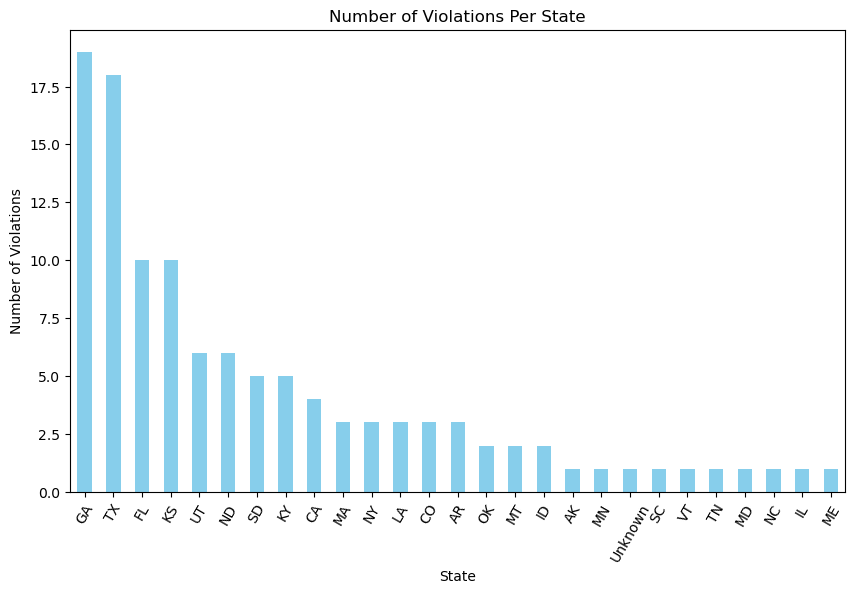

In [20]:
## your code here
import matplotlib.pyplot as plt

state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

def extract_state(city_state):
    if isinstance(city_state, str):
        return city_state.split(', ')[-1]
    else:
        return "Unknown" 

debar['State'] = debar['City, State'].apply(extract_state)

def clean_city_state(state):
    for keyword, replacement in state_abbreviations.items():
        if keyword in state:
            return state.replace(keyword, replacement)
    return state

debar['State'] = debar['State'].apply(clean_city_state)

state_violation_counts = debar['State'].value_counts()

print(state_violation_counts)

state_violation_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))

plt.title('Number of Violations Per State')
plt.xlabel('State')
plt.ylabel('Number of Violations')
plt.xticks(rotation=60) 

plt.show()